In [1]:
import pandas as pd
import numpy as  np
from scipy.optimize import minimize
import random
from sklearn.metrics import mean_squared_error as mse
import time

In [2]:
def get_rhat(u,v):
    return np.matmul(u,np.transpose(v))

In [3]:
def cal_error(r,rhat):
    return 0.5 * np.sum(np.square(r - rhat))

![mf-algo](https://user-images.githubusercontent.com/16842872/48115953-91f82100-e232-11e8-84d1-229aabc9c1dc.png)

In [107]:
def matrix_factorization(ratings,alpha,steps,k=3,beta=0.001):
    r=ratings
    row = (r.shape[0])
    col = (r.shape[1])
    
    np.random.seed(1234)
    u = np.random.rand(row,k)
    v = np.random.rand(col,k)
    
    e = r - get_rhat(u,v)
    e = np.array(pd.DataFrame(e).fillna(0))

    for s in range(steps):
        u_c = u + alpha * (np.matmul(e,v) - beta * u)
        v_c = v + alpha * (np.matmul(e.T,u) - beta * v)
       
        u = np.copy(u_c)
        v = np.copy(v_c)
        e = r - get_rhat(u,v)
        e = np.array(pd.DataFrame(e).fillna(0))
    return get_rhat(u,v)

## Implementing on a Sample Case

In [108]:
R = [[5,3,np.nan,1],[4,np.nan,np.nan,1],[1,1,np.nan,5],[1,np.nan,np.nan,4],[np.nan,1,5,4]]
R = np.array(R)
R

array([[ 5.,  3., nan,  1.],
       [ 4., nan, nan,  1.],
       [ 1.,  1., nan,  5.],
       [ 1., nan, nan,  4.],
       [nan,  1.,  5.,  4.]])

In [109]:
predicted_R = matrix_factorization(R,0.002,1000,k=3)
predicted_R

array([[5.00427396, 2.98685529, 3.2893264 , 0.99878629],
       [3.99488629, 2.1252455 , 3.00021632, 0.99817854],
       [1.01440431, 0.96467895, 4.64274961, 4.99679527],
       [0.99263407, 0.42430888, 4.14483226, 3.99562838],
       [2.37993107, 1.04496312, 4.98316256, 4.01216043]])

In [110]:
true = [[0,0],[0,1],[0,3],[1,0],[1,3],[2,0],[2,1],[2,3],[3,0],[3,3],[4,1],[4,2],[4,3]]

In [111]:
def fetch_ratings(ratings, predicted, coords):
    y_true = list()
    y_pred = list()
    for i in coords:
        y_true.append(ratings[i[0]][i[1]])
        y_pred.append(predicted[i[0]][i[1]])
    return(y_true,y_pred)

In [112]:
y_true, y_pred = fetch_ratings(R, predicted_R, true)

In [113]:
print('RMSE:', np.sqrt(mse(y_true, y_pred)))

RMSE: 0.018003734083510775


## Experiment 1: Small Dataset [ 640 Users x 100 Movies]

In [114]:
ratings = pd.read_csv('data/ratings-small.csv')

In [115]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [116]:
print(' Number of Users:', len(ratings.userId.unique()),'\n','Number of Movies:', len(ratings.movieId.unique()))

 Number of Users: 610 
 Number of Movies: 9724


In [117]:
# Selecting Top 100 Movies
data = ratings

common_movies = data.groupby('movieId').size().reset_index(name='counts')
common_movies = common_movies.sort_values(ascending=False, by=['counts']);
movies = list(common_movies.head(100)['movieId']);
#movies

In [118]:
r2 = ratings.pivot(index='userId', columns='movieId', values='rating');
r2_ = r2.filter(items = movies)
r3 = np.asarray(r2_)

In [119]:
r2_.shape

(610, 100)

In [120]:
def get_indices(data):
    indice = list()
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if np.isnan(data[i][j]) == False:
                indice.append([i,j])
            else:
                pass
    return(indice)

In [121]:
indice = get_indices(r3)
print('Number of Available Data Points:', len(indice))

Number of Available Data Points: 16185


In [122]:
print('Total number of possible entries in Data Matrix:', r3.shape[0]*r3.shape[1])

Total number of possible entries in Data Matrix: 61000


In [123]:
print('Sparsity of Given Data Matrix: {} %'.format( (1 - (16185)/61000.0)*100 )) 

Sparsity of Given Data Matrix: 73.4672131147541 %


In [124]:
ratio = 0.1

In [125]:
import time

start = time.time()
matrix_factorization(r3,0.0002,1000)
end = time.time()

print('Time Taken:', end-start)

Time Taken: 1.3206217288970947


In [126]:
def select_test(indice, ratio):
    random.seed(2018)
    test = random.sample(indice, int(ratio*len(indice)))
    return(test)

In [127]:
test = select_test(indice, 0.1)

In [128]:
def mutate_ratings(ratings,test):
    rt = ratings.copy()
    for i in test:
        rt[i[0]][i[1]] = np.nan
    return (rt)

In [129]:
# Masking known entries kept in Test Set to predict during Matrix Factorization
new_r3 = mutate_ratings(r3, test)

In [130]:
start = time.time()
pred_new_r3_1 = matrix_factorization(new_r3, alpha = 0.0002, steps = 1000, k = 1)
end1 = time.time()
print(end1-start)

pred_new_r3_2 = matrix_factorization(new_r3, alpha = 0.0002, steps = 1000, k = 2)
end2 = time.time()
print(end2-start)

pred_new_r3_3 = matrix_factorization(new_r3, alpha = 0.0002, steps = 1000, k = 3)
end3 = time.time()
print(end3-start)

pred_new_r3_4 = matrix_factorization(new_r3, alpha = 0.0002, steps = 1000, k = 4)
end4 = time.time()
print(end4-start)

pred_new_r3_5 = matrix_factorization(new_r3, alpha = 0.0002, steps = 1000, k = 5)
end5 = time.time()
print(end5-start)

1.2553675174713135
2.567974090576172
3.8753459453582764
5.229209899902344
6.521210193634033


In [131]:
from tqdm import tqdm

In [132]:
def rmse_k(data, k):
    indice = get_indices(data)
    ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
    
    scores = dict()
    
    for ratio in tqdm(ratios):
        test = select_test(indice, ratio)
        new_data = mutate_ratings(data, test)
        pred = matrix_factorization(new_data,0.0002,1000, k = k)
        y_true, y_pred = fetch_ratings(data, pred, test)
        score = np.sqrt(mse(y_true, y_pred))
        scores[str(ratio)] = score
        
    return(scores)

In [133]:
def fetch_ratings(ratings, predicted, coords):
    y_true = list()
    y_pred = list()
    for i in coords:
        y_true.append(ratings[i[0]][i[1]])
        y_pred.append(predicted[i[0]][i[1]])
    return(y_true,y_pred)

In [134]:
val_1 = rmse_k(r3, k= 1)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.14s/it]


In [135]:
val_2 = rmse_k(r3, k= 2)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]


In [136]:
val_3 = rmse_k(r3, k= 3)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]


In [137]:
val_4 = rmse_k(r3, k= 4)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]


In [138]:
val_5 = rmse_k(r3, k= 5)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.24s/it]


In [139]:
val_6 = rmse_k(r3, k= 6)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.27s/it]


In [140]:
np.save('val_1.npy', val_1) 
np.save('val_2.npy', val_2) 
np.save('val_3.npy', val_3)
np.save('val_4.npy', val_4)
np.save('val_5.npy', val_5)
np.save('val_6.npy', val_6)

In [141]:
val_1 = np.load('val_1.npy').item()
val_2 = np.load('val_2.npy').item()
val_3 = np.load('val_3.npy').item()
val_4 = np.load('val_4.npy').item()
val_5 = np.load('val_5.npy').item()
val_6 = np.load('val_6.npy').item()

In [142]:
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

In [143]:
v1 = [val_1[str(key)] for key in ratios ]
v2 = [val_2[str(key)] for key in ratios ]
v3 = [val_3[str(key)] for key in ratios ]
v4 = [val_4[str(key)] for key in ratios ]
v5 = [val_5[str(key)] for key in ratios ]
v6 = [val_6[str(key)] for key in ratios ]

In [144]:
# Sample of RMSE values stored for k= 2 for varying Train-Test split sizes
v2

[0.8193777302057281,
 0.825173197913313,
 0.8500553899043565,
 0.8953655246145388,
 1.138294270489958]

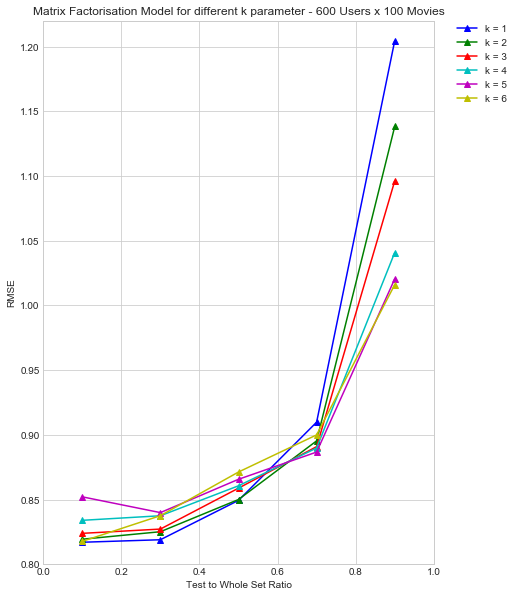

In [145]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,10))
plt.style.use('seaborn-whitegrid')

ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

plt.plot(ratios, v1,'b^-', label='k = 1')
plt.plot(ratios, v2,'g^-', label='k = 2')
plt.plot(ratios, v3,'r^-', label='k = 3')
plt.plot(ratios, v4,'c^-', label='k = 4')
plt.plot(ratios, v5,'m^-', label='k = 5')
plt.plot(ratios, v6,'y^-', label='k = 6')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Matrix Factorisation Model for different k parameter - 600 Users x 100 Movies')
plt.xlabel('Test to Whole Set Ratio')
plt.ylabel('RMSE')
plt.xlim(0, 1.0)
plt.ylim(0.8, 1.22)
plt.savefig('img/MF-small-updated.png')
plt.show()

## Experiment 2- Large Dataset [ 10,000 Users x 88 Movies]

In [146]:
ratings_l = pd.read_csv('data/ratings-large.csv')

In [147]:
ratings_l.shape

(27753444, 4)

In [148]:
#users = ratings_large.

random.seed(2018)
movies = ratings_l.movieId.unique()

M= 120
movies_sub = random.sample(list(movies),M)
ratings_l_sub1 = ratings_l[(ratings_l.movieId.isin(movies_sub))]

users = ratings_l_sub1.userId.unique()
U = 10000
users_sub = random.sample(list(users),U)
ratings_l_sub2 = ratings_l_sub1[(ratings_l_sub1.userId.isin(users_sub))]

In [149]:
ratings_l_sub2.head(10)

,userId,movieId,rating,timestamp
5170,56,3910,4.5,1274781644
5501,56,104074,1.0,1415584315
6185,71,3503,4.5,1257872644
6190,71,3910,4.0,1257873095
9199,88,4388,2.5,1271586530
9576,92,7,3.0,1132007489
15550,160,4388,3.5,1077931846
15644,160,6852,4.5,1077932317
15689,163,7,4.0,942863332
15955,164,460,2.0,835691373


In [150]:
ratings_l_sub2.shape

(14331, 4)

In [151]:
ratings = ratings_l_sub2
print(' Number of Users:', len(ratings.userId.unique()),'\n','Number of Movies:', len(ratings.movieId.unique()))

 Number of Users: 10000 
 Number of Movies: 88


In [152]:
ratings.to_csv('data/ratings-large-2.csv', index=False)

In [153]:
ratings = pd.read_csv('data/ratings-large-2.csv')

In [154]:
r2 = ratings.pivot(index='userId', columns='movieId', values='rating');
r3 = np.asarray(r2)

In [155]:
r3.shape

(10000, 88)

In [156]:
indice = get_indices(r3)
print('Number of Available Data Points:', len(indice))
print('Total number of possible entries in Data Matrix:', r3.shape[0]*r3.shape[1])
print('Sparsity of Given Data Matrix: {} %'.format( (1 - (10357)/410000.0)*100 )) 

Number of Available Data Points: 14331
Total number of possible entries in Data Matrix: 880000
Sparsity of Given Data Matrix: 97.47390243902439 %


In [157]:
test = select_test(indice, 0.1)
new_r3 = mutate_ratings(r3, test)

In [158]:
start = time.time()
pred_new_r3_1 = matrix_factorization(new_r3, alpha = 0.0002, steps = 1000, k = 1)
end1 = time.time()
print(end1-start)

29.44034433364868


In [159]:
pred_new_r3_1.shape

(10000, 88)

In [160]:
val_l1 = rmse_k(r3, k= 1)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:26<00:00, 29.36s/it]


In [161]:
val_l2 = rmse_k(r3, k= 2)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:31<00:00, 30.22s/it]


In [162]:
val_l3 = rmse_k(r3, k= 3)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:30<00:00, 30.11s/it]


In [163]:
val_l4 = rmse_k(r3, k= 4)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:31<00:00, 30.38s/it]


In [164]:
val_l5 = rmse_k(r3, k= 5)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:31<00:00, 30.29s/it]


In [165]:
val_l6 = rmse_k(r3, k= 6)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:36<00:00, 31.25s/it]


In [166]:
val_l7 = rmse_k(r3, k= 7)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:38<00:00, 31.66s/it]


In [167]:
val_l8 = rmse_k(r3, k= 8)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:39<00:00, 31.80s/it]


In [168]:
val_l9 = rmse_k(r3, k= 9)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:34<00:00, 31.01s/it]


In [169]:
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

v1 = [val_l1[str(key)] for key in ratios ]
v2 = [val_l2[str(key)] for key in ratios ]
v3 = [val_l3[str(key)] for key in ratios ]
v4 = [val_l4[str(key)] for key in ratios ]
v5 = [val_l5[str(key)] for key in ratios ]
v6 = [val_l6[str(key)] for key in ratios ]
v7 = [val_l7[str(key)] for key in ratios ]
v8 = [val_l8[str(key)] for key in ratios ]
v9 = [val_l9[str(key)] for key in ratios ]

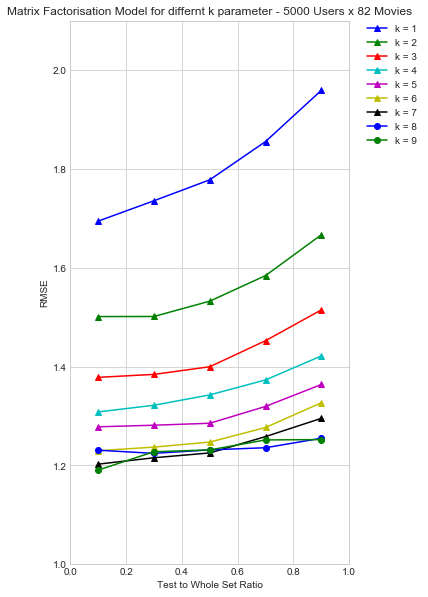

In [170]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,10))
plt.style.use('seaborn-whitegrid')

ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

plt.plot(ratios, v1,'b^-', label='k = 1')
plt.plot(ratios, v2,'g^-', label='k = 2')
plt.plot(ratios, v3,'r^-', label='k = 3')
plt.plot(ratios, v4,'c^-', label='k = 4')
plt.plot(ratios, v5,'m^-', label='k = 5')
plt.plot(ratios, v6,'y^-', label='k = 6')
plt.plot(ratios, v7,'k^-', label='k = 7')
plt.plot(ratios, v8,'bo-', label='k = 8')
plt.plot(ratios, v9,'go-', label='k = 9')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Matrix Factorisation Model for differnt k parameter - 5000 Users x 82 Movies')
plt.xlabel('Test to Whole Set Ratio')
plt.ylabel('RMSE')
plt.xlim(0, 1.0)
plt.ylim(1.0, 2.1)
plt.savefig('img/MF-large.png')
plt.show()